<a href="https://colab.research.google.com/github/felizzi/Glaucoma_Studies/blob/main/Glaucoma_model_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Glaucoma Health Economic Model with Custom Transition Probabilities ===

EXAMPLE: Comparing AI Implementation vs No AI Implementation

=== SCENARIO COMPARISON: AI Implementation vs No AI ===

Transition Probability Comparison:
Parameter                | No AI (Untreated) | AI Implementation (Treated) | Reduction
--------------------------------------------------------------------------------
mild_to_moderate     |      0.180        |      0.080             |   55.6%
moderate_to_severe   |      0.140        |      0.060             |   57.1%
severe_to_vi         |      0.120        |      0.040             |   66.7%


Running deterministic analyses...
Running probabilistic analyses...
Running 200 simulations...
  Simulation 0
Running 200 simulations...
  Simulation 0
DETERMINISTIC COMPARISON:
                    Metric   No_AI AI_Implementation Difference_AI_vs_NoAI
 Total Cost (Undiscounted) $28,998           $22,159               $-6,839
   Total Cost (Discounted) $26,573         

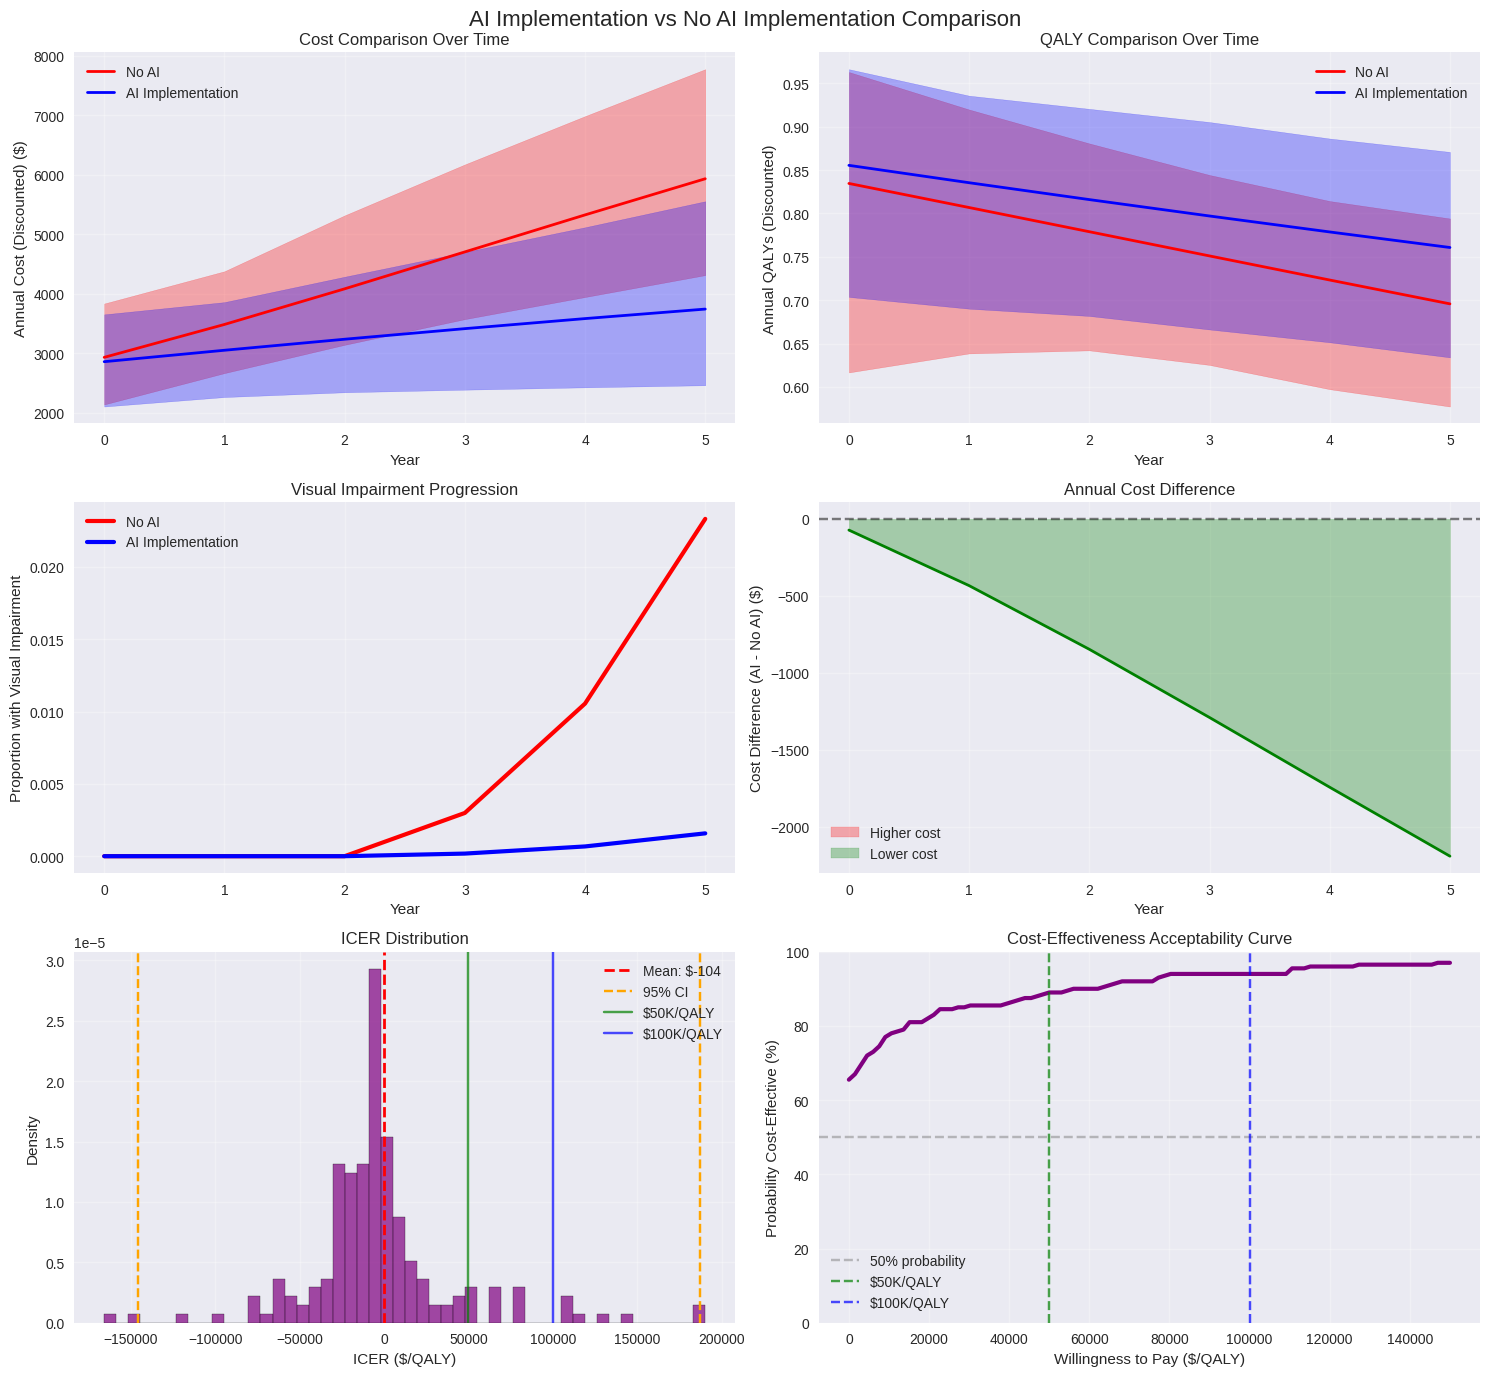


JUPYTER USAGE EXAMPLES:
# Quick comparison with default values:
results = compare_scenarios(years=10, n_sims=1000)

# Custom transition probabilities:
ai_trans = {'mild_to_moderate': 0.08, 'moderate_to_severe': 0.06, 'severe_to_vi': 0.04}
no_ai_trans = {'mild_to_moderate': 0.16, 'moderate_to_severe': 0.13, 'severe_to_vi': 0.11}
results = compare_scenarios(ai_transitions=ai_trans, no_ai_transitions=no_ai_trans)

# Individual scenarios with custom transitions:
ai_model = quick_model('ai', mild_to_moderate=0.09, severe_to_vi=0.05)
no_ai_model = quick_model('no_ai', mild_to_moderate=0.17)

# Quick run with custom transitions:
model, results = quick_run('ai', mild_to_moderate=0.07, moderate_to_severe=0.05)

# Show parameters for specific scenario:
params_df = show_parameters('ai', mild_to_moderate=0.08)
print(params_df)


In [2]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

@dataclass
class Parameter:
    """Simple parameter class with sampling capability"""
    mean: float
    std: float
    dist_type: str = 'normal'  # normal, gamma, beta

    def sample(self, n=1):
        """Sample from parameter distribution"""
        if self.dist_type == 'gamma':
            shape = (self.mean / self.std) ** 2
            scale = self.std ** 2 / self.mean
            return np.random.gamma(shape, scale, n)
        elif self.dist_type == 'beta':
            # Assume beta is for probabilities (0-1)
            alpha = self.mean * (self.mean * (1 - self.mean) / self.std**2 - 1)
            beta = (1 - self.mean) * (self.mean * (1 - self.mean) / self.std**2 - 1)
            return np.random.beta(max(alpha, 0.1), max(beta, 0.1), n)
        else:  # normal
            return np.maximum(0, np.random.normal(self.mean, self.std, n))

class GlaucomaParameters:
    """All model parameters in one place - easy to edit"""

    def __init__(self, scenario_name="Default",
                 mild_to_moderate=0.15, moderate_to_severe=0.12, severe_to_vi=0.10):
        self.scenario_name = scenario_name

        # COSTS (annual, in USD)
        self.costs = {
            'monitoring_mild': Parameter(500, 100, 'gamma'),
            'monitoring_moderate': Parameter(800, 150, 'gamma'),
            'monitoring_severe': Parameter(1200, 200, 'gamma'),
            'monitoring_vi': Parameter(1500, 250, 'gamma'),

            'treatment_mild': Parameter(1200, 300, 'gamma'),
            'treatment_moderate': Parameter(2000, 400, 'gamma'),
            'treatment_severe': Parameter(3500, 600, 'gamma'),
            'treatment_vi': Parameter(4000, 700, 'gamma'),

            'other_mild': Parameter(200, 50, 'gamma'),
            'other_moderate': Parameter(800, 200, 'gamma'),
            'other_severe': Parameter(2500, 500, 'gamma'),
            'other_vi': Parameter(3000, 600, 'gamma'),  # includes additional meds

            'productivity_mild': Parameter(1000, 300, 'gamma'),
            'productivity_moderate': Parameter(3000, 600, 'gamma'),
            'productivity_severe': Parameter(8000, 1500, 'gamma'),
            'productivity_vi': Parameter(15000, 3000, 'gamma'),
        }

        # UTILITIES (0-1 scale)
        self.utilities = {
            'utility_mild': Parameter(0.85, 0.08, 'beta'),
            'utility_moderate': Parameter(0.75, 0.10, 'beta'),
            'utility_severe': Parameter(0.60, 0.12, 'beta'),
            'utility_vi': Parameter(0.40, 0.15, 'beta'),
        }

        # TRANSITION PROBABILITIES (annual) - USER SPECIFIED
        self.transitions = {
            'mild_to_moderate': Parameter(mild_to_moderate, 0.05, 'beta'),
            'moderate_to_severe': Parameter(moderate_to_severe, 0.04, 'beta'),
            'severe_to_vi': Parameter(severe_to_vi, 0.03, 'beta'),
        }

        # DISCOUNT RATES (annual)
        self.discount_rates = {
            'cost_discount': Parameter(0.03, 0.01, 'beta'),     # 3% for costs
            'health_discount': Parameter(0.015, 0.005, 'beta'), # 1.5% for health outcomes
        }

    @classmethod
    def create_ai_scenario(cls, mild_to_moderate=0.10, moderate_to_severe=0.08, severe_to_vi=0.06):
        """Create parameters for AI implementation scenario with custom transition rates"""
        return cls(
            scenario_name="AI Implementation",
            mild_to_moderate=mild_to_moderate,
            moderate_to_severe=moderate_to_severe,
            severe_to_vi=severe_to_vi
        )

    @classmethod
    def create_no_ai_scenario(cls, mild_to_moderate=0.15, moderate_to_severe=0.12, severe_to_vi=0.10):
        """Create parameters for no AI implementation scenario with custom transition rates"""
        return cls(
            scenario_name="No AI Implementation",
            mild_to_moderate=mild_to_moderate,
            moderate_to_severe=moderate_to_severe,
            severe_to_vi=severe_to_vi
        )

    def sample_all(self):
        """Sample all parameters once"""
        sample = {}
        for category in [self.costs, self.utilities, self.transitions, self.discount_rates]:
            for name, param in category.items():
                sample[name] = param.sample(1)[0]
        return sample

    def get_summary(self):
        """Get parameter summary as DataFrame"""
        data = []
        for category_name, category in [('Costs', self.costs),
                                       ('Utilities', self.utilities),
                                       ('Transitions', self.transitions),
                                       ('Discount_Rates', self.discount_rates)]:
            for name, param in category.items():
                data.append({
                    'Category': category_name,
                    'Parameter': name,
                    'Mean': param.mean,
                    'Std': param.std,
                    'Distribution': param.dist_type
                })
        return pd.DataFrame(data)

class GlaucomaModel:
    """Streamlined Glaucoma Health Economic Model"""

    def __init__(self, params=None):
        self.params = params or GlaucomaParameters()
        self.states = ['Mild', 'Moderate', 'Severe', 'VI']
        self.scenario_name = self.params.scenario_name

    def get_transition_matrix(self, sample):
        """Build transition matrix from sampled parameters"""
        p1 = sample['mild_to_moderate']
        p2 = sample['moderate_to_severe']
        p3 = sample['severe_to_vi']

        # Ensure valid probabilities
        p1, p2, p3 = np.clip([p1, p2, p3], 0, 1)

        return np.array([
            [1-p1, p1, 0, 0],      # Mild
            [0, 1-p2, p2, 0],      # Moderate
            [0, 0, 1-p3, p3],      # Severe
            [0, 0, 0, 1]           # VI (absorbing)
        ])

    def simulate_cohort(self, initial_dist, years, sample):
        """Simulate cohort over time"""
        n_states = len(self.states)
        cohort = np.zeros((years + 1, n_states))
        cohort[0] = initial_dist

        trans_matrix = self.get_transition_matrix(sample)

        # Evolve cohort
        for year in range(years):
            cohort[year + 1] = cohort[year] @ trans_matrix

        return cohort

    def calculate_outcomes(self, cohort, sample):
        """Calculate costs and QALYs for each year with discounting"""
        years = len(cohort)
        costs = np.zeros(years)
        qalys = np.zeros(years)
        costs_discounted = np.zeros(years)
        qalys_discounted = np.zeros(years)

        # Get discount rates
        cost_discount_rate = sample['cost_discount']
        health_discount_rate = sample['health_discount']

        # State-specific values
        state_costs = [
            sample['monitoring_mild'] + sample['treatment_mild'] +
            sample['other_mild'] + sample['productivity_mild'],

            sample['monitoring_moderate'] + sample['treatment_moderate'] +
            sample['other_moderate'] + sample['productivity_moderate'],

            sample['monitoring_severe'] + sample['treatment_severe'] +
            sample['other_severe'] + sample['productivity_severe'],

            sample['monitoring_vi'] + sample['treatment_vi'] +
            sample['other_vi'] + sample['productivity_vi']
        ]

        state_utilities = [
            sample['utility_mild'],
            sample['utility_moderate'],
            sample['utility_severe'],
            sample['utility_vi']
        ]

        # Calculate annual totals with and without discounting
        for year in range(years):
            # Undiscounted
            costs[year] = np.sum(cohort[year] * state_costs)
            qalys[year] = np.sum(cohort[year] * state_utilities)

            # Discounted (year 0 has no discounting)
            cost_discount_factor = 1 / (1 + cost_discount_rate) ** year
            health_discount_factor = 1 / (1 + health_discount_rate) ** year

            costs_discounted[year] = costs[year] * cost_discount_factor
            qalys_discounted[year] = qalys[year] * health_discount_factor

        return costs, qalys, costs_discounted, qalys_discounted, state_costs, state_utilities

    def run_deterministic(self, initial_dist=None, years=10):
        """Run with mean parameter values"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]  # Start all in mild

        # Use mean values
        sample = {}
        for category in [self.params.costs, self.params.utilities,
                        self.params.transitions, self.params.discount_rates]:
            for name, param in category.items():
                sample[name] = param.mean

        cohort = self.simulate_cohort(initial_dist, years, sample)
        costs, qalys, costs_disc, qalys_disc, state_costs, state_utilities = self.calculate_outcomes(cohort, sample)

        # Create detailed traces
        traces = self.create_detailed_traces(cohort, costs, qalys, costs_disc, qalys_disc,
                                           state_costs, state_utilities, sample)

        return {
            'cohort': cohort,
            'costs': costs,
            'qalys': qalys,
            'costs_discounted': costs_disc,
            'qalys_discounted': qalys_disc,
            'total_cost': np.sum(costs),
            'total_qalys': np.sum(qalys),
            'total_cost_discounted': np.sum(costs_disc),
            'total_qalys_discounted': np.sum(qalys_disc),
            'traces': traces,
            'state_costs': state_costs,
            'state_utilities': state_utilities,
            'sample_params': sample
        }

    def run_probabilistic(self, n_sims=1000, initial_dist=None, years=10):
        """Run Monte Carlo simulation"""
        if initial_dist is None:
            initial_dist = [1, 0, 0, 0]

        print(f"Running {n_sims} simulations...")

        # Storage
        all_costs = np.zeros((n_sims, years + 1))
        all_qalys = np.zeros((n_sims, years + 1))
        all_costs_disc = np.zeros((n_sims, years + 1))
        all_qalys_disc = np.zeros((n_sims, years + 1))
        all_cohorts = np.zeros((n_sims, years + 1, 4))

        for i in range(n_sims):
            if i % 200 == 0:
                print(f"  Simulation {i}")

            sample = self.params.sample_all()
            cohort = self.simulate_cohort(initial_dist, years, sample)
            costs, qalys, costs_disc, qalys_disc, _, _ = self.calculate_outcomes(cohort, sample)

            all_costs[i] = costs
            all_qalys[i] = qalys
            all_costs_disc[i] = costs_disc
            all_qalys_disc[i] = qalys_disc
            all_cohorts[i] = cohort

        return {
            'costs_mean': np.mean(all_costs, axis=0),
            'costs_ci': np.percentile(all_costs, [2.5, 97.5], axis=0),
            'qalys_mean': np.mean(all_qalys, axis=0),
            'qalys_ci': np.percentile(all_qalys, [2.5, 97.5], axis=0),
            'costs_disc_mean': np.mean(all_costs_disc, axis=0),
            'costs_disc_ci': np.percentile(all_costs_disc, [2.5, 97.5], axis=0),
            'qalys_disc_mean': np.mean(all_qalys_disc, axis=0),
            'qalys_disc_ci': np.percentile(all_qalys_disc, [2.5, 97.5], axis=0),
            'cohort_mean': np.mean(all_cohorts, axis=0),
            'all_costs': all_costs,
            'all_qalys': all_qalys,
            'all_costs_disc': all_costs_disc,
            'all_qalys_disc': all_qalys_disc
        }

    def plot_results(self, results, title="Glaucoma Model Results", show_discounted=True):
        """Create summary plots"""
        years = len(results['costs_mean'])
        time_points = np.arange(years)

        if show_discounted and 'costs_disc_mean' in results:
            fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 12))
        else:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

        fig.suptitle(title, fontsize=16)

        # 1. Costs over time (undiscounted)
        ax1.plot(time_points, results['costs_mean'], 'b-', linewidth=2, label='Mean')
        ax1.fill_between(time_points, results['costs_ci'][0], results['costs_ci'][1],
                        alpha=0.3, label='95% CI')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Annual Cost ($)')
        ax1.set_title('Costs Over Time (Undiscounted)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. QALYs over time (undiscounted)
        ax2.plot(time_points, results['qalys_mean'], 'g-', linewidth=2, label='Mean')
        ax2.fill_between(time_points, results['qalys_ci'][0], results['qalys_ci'][1],
                        alpha=0.3, label='95% CI')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Annual QALYs')
        ax2.set_title('QALYs Over Time (Undiscounted)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. State distribution
        colors = ['skyblue', 'orange', 'lightcoral', 'red']
        bottom = np.zeros(years)
        for i, state in enumerate(self.states):
            ax3.bar(time_points, results['cohort_mean'][:, i],
                   bottom=bottom, label=state, color=colors[i], alpha=0.8)
            bottom += results['cohort_mean'][:, i]
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Proportion in State')
        ax3.set_title('Disease Progression')
        ax3.legend()

        # 4. Cost comparison (discounted vs undiscounted)
        if show_discounted and 'costs_disc_mean' in results:
            ax4.plot(time_points, results['costs_mean'], 'b-', linewidth=2, label='Undiscounted')
            ax4.plot(time_points, results['costs_disc_mean'], 'r-', linewidth=2, label='Discounted (3%)')
            ax4.set_xlabel('Year')
            ax4.set_ylabel('Annual Cost ($)')
            ax4.set_title('Cost Comparison')
            ax4.legend()
            ax4.grid(True, alpha=0.3)

            # 5. Discounted costs over time
            ax5.plot(time_points, results['costs_disc_mean'], 'r-', linewidth=2, label='Mean')
            ax5.fill_between(time_points, results['costs_disc_ci'][0], results['costs_disc_ci'][1],
                            alpha=0.3, color='red', label='95% CI')
            ax5.set_xlabel('Year')
            ax5.set_ylabel('Annual Cost ($)')
            ax5.set_title('Costs Over Time (Discounted 3%)')
            ax5.legend()
            ax5.grid(True, alpha=0.3)

            # 6. Discounted QALYs over time
            ax6.plot(time_points, results['qalys_disc_mean'], 'purple', linewidth=2, label='Mean')
            ax6.fill_between(time_points, results['qalys_disc_ci'][0], results['qalys_disc_ci'][1],
                            alpha=0.3, color='purple', label='95% CI')
            ax6.set_xlabel('Year')
            ax6.set_ylabel('Annual QALYs')
            ax6.set_title('QALYs Over Time (Discounted 1.5%)')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
        else:
            # 4. Final year cost distribution (if no discounting shown)
            if 'all_costs' in results:
                final_costs = results['all_costs'][:, -1]
                ax4.hist(final_costs, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')
                ax4.axvline(np.mean(final_costs), color='red', linestyle='--', linewidth=2, label='Mean')
                ax4.set_xlabel(f'Total Cost - Year {years-1} ($)')
                ax4.set_ylabel('Density')
                ax4.set_title('Cost Distribution (Final Year)')
                ax4.legend()

        plt.tight_layout()
        plt.show()

        return fig

    def summary_table(self, results, years=None, show_discounted=True):
        """Create results summary table"""
        if years is None:
            years = len(results['costs_mean'])

        data = []
        for year in range(min(years, len(results['costs_mean']))):
            row = {
                'Year': year,
                'Cost_Mean': f"${results['costs_mean'][year]:,.0f}",
                'Cost_95CI': f"${results['costs_ci'][0][year]:,.0f} - ${results['costs_ci'][1][year]:,.0f}",
                'QALY_Mean': f"{results['qalys_mean'][year]:.3f}",
                'QALY_95CI': f"{results['qalys_ci'][0][year]:.3f} - {results['qalys_ci'][1][year]:.3f}",
            }

            # Add discounted values if available
            if show_discounted and 'costs_disc_mean' in results:
                row['Cost_Disc_Mean'] = f"${results['costs_disc_mean'][year]:,.0f}"
                row['QALY_Disc_Mean'] = f"{results['qalys_disc_mean'][year]:.3f}"

            # Add state proportions
            for i, state in enumerate(self.states):
                row[f'{state}_%'] = f"{results['cohort_mean'][year, i]*100:.1f}%"

            data.append(row)

        return pd.DataFrame(data)

    def get_total_outcomes(self, results):
        """Get total discounted and undiscounted outcomes"""
        total_cost = np.sum(results['costs_mean'])
        total_qaly = np.sum(results['qalys_mean'])

        outcomes = {
            'Total Cost (Undiscounted)': f"${total_cost:,.0f}",
            'Total QALYs (Undiscounted)': f"{total_qaly:.2f}",
        }

        if 'costs_disc_mean' in results:
            total_cost_disc = np.sum(results['costs_disc_mean'])
            total_qaly_disc = np.sum(results['qalys_disc_mean'])

            outcomes['Total Cost (Discounted)'] = f"${total_cost_disc:,.0f}"
            outcomes['Total QALYs (Discounted)'] = f"{total_qaly_disc:.2f}"
            outcomes['Cost per QALY (Discounted)'] = f"${total_cost_disc/total_qaly_disc:,.0f}" if total_qaly_disc > 0 else "N/A"

        return outcomes

    def create_detailed_traces(self, cohort, costs, qalys, costs_disc, qalys_disc,
                              state_costs, state_utilities, sample):
        """Create detailed year-by-year traces"""
        years = len(cohort)

        # Create comprehensive trace data
        trace_data = []

        for year in range(years):
            # Calculate discount factors
            cost_discount_factor = 1 / (1 + sample['cost_discount']) ** year
            health_discount_factor = 1 / (1 + sample['health_discount']) ** year

            # State-wise costs and utilities for this year
            state_costs_year = cohort[year] * state_costs
            state_utilities_year = cohort[year] * state_utilities

            # Discounted state-wise values
            state_costs_disc_year = state_costs_year * cost_discount_factor
            state_utilities_disc_year = state_utilities_year * health_discount_factor

            row = {
                'Year': year,

                # State proportions
                'Prop_Mild': cohort[year][0],
                'Prop_Moderate': cohort[year][1],
                'Prop_Severe': cohort[year][2],
                'Prop_VI': cohort[year][3],

                # Total costs and utilities (undiscounted)
                'Total_Cost': costs[year],
                'Total_QALY': qalys[year],

                # Total costs and utilities (discounted)
                'Total_Cost_Disc': costs_disc[year],
                'Total_QALY_Disc': qalys_disc[year],

                # State-specific costs (undiscounted)
                'Cost_Mild': state_costs_year[0],
                'Cost_Moderate': state_costs_year[1],
                'Cost_Severe': state_costs_year[2],
                'Cost_VI': state_costs_year[3],

                # State-specific utilities (undiscounted)
                'QALY_Mild': state_utilities_year[0],
                'QALY_Moderate': state_utilities_year[1],
                'QALY_Severe': state_utilities_year[2],
                'QALY_VI': state_utilities_year[3],

                # State-specific costs (discounted)
                'Cost_Disc_Mild': state_costs_disc_year[0],
                'Cost_Disc_Moderate': state_costs_disc_year[1],
                'Cost_Disc_Severe': state_costs_disc_year[2],
                'Cost_Disc_VI': state_costs_disc_year[3],

                # State-specific utilities (discounted)
                'QALY_Disc_Mild': state_utilities_disc_year[0],
                'QALY_Disc_Moderate': state_utilities_disc_year[1],
                'QALY_Disc_Severe': state_utilities_disc_year[2],
                'QALY_Disc_VI': state_utilities_disc_year[3],

                # Discount factors
                'Cost_Discount_Factor': cost_discount_factor,
                'Health_Discount_Factor': health_discount_factor,

                # Per-person state costs and utilities (for reference)
                'Cost_Per_Person_Mild': state_costs[0],
                'Cost_Per_Person_Moderate': state_costs[1],
                'Cost_Per_Person_Severe': state_costs[2],
                'Cost_Per_Person_VI': state_costs[3],

                'Utility_Per_Person_Mild': state_utilities[0],
                'Utility_Per_Person_Moderate': state_utilities[1],
                'Utility_Per_Person_Severe': state_utilities[2],
                'Utility_Per_Person_VI': state_utilities[3],
            }

            trace_data.append(row)

        return pd.DataFrame(trace_data)

    def get_trace_summary(self, traces, format_numbers=True):
        """Get a clean summary of traces for display"""
        summary_cols = ['Year', 'Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI',
                       'Total_Cost', 'Total_Cost_Disc', 'Total_QALY', 'Total_QALY_Disc']

        summary = traces[summary_cols].copy()

        if format_numbers:
            # Format for better display
            for col in ['Prop_Mild', 'Prop_Moderate', 'Prop_Severe', 'Prop_VI']:
                summary[col] = summary[col].apply(lambda x: f"{x:.3f}")

            summary['Total_Cost'] = summary['Total_Cost'].apply(lambda x: f"${x:,.0f}")
            summary['Total_Cost_Disc'] = summary['Total_Cost_Disc'].apply(lambda x: f"${x:,.0f}")
            summary['Total_QALY'] = summary['Total_QALY'].apply(lambda x: f"{x:.3f}")
            summary['Total_QALY_Disc'] = summary['Total_QALY_Disc'].apply(lambda x: f"{x:.3f}")

        return summary

# Scenario comparison functions for Jupyter
def compare_scenarios(years=10, n_sims=500,
                     ai_transitions={'mild_to_moderate': 0.10, 'moderate_to_severe': 0.08, 'severe_to_vi': 0.06},
                     no_ai_transitions={'mild_to_moderate': 0.15, 'moderate_to_severe': 0.12, 'severe_to_vi': 0.10}):
    """Compare AI vs No AI scenarios with custom transition probabilities"""
    print("=== SCENARIO COMPARISON: AI Implementation vs No AI ===\n")

    # Create both scenarios with custom transition rates
    ai_params = GlaucomaParameters.create_ai_scenario(**ai_transitions)
    no_ai_params = GlaucomaParameters.create_no_ai_scenario(**no_ai_transitions)

    # Create models
    ai_model = GlaucomaModel(ai_params)
    no_ai_model = GlaucomaModel(no_ai_params)

    print("Transition Probability Comparison:")
    print("Parameter                | No AI (Untreated) | AI Implementation (Treated) | Reduction")
    print("-" * 80)
    for param_name in ['mild_to_moderate', 'moderate_to_severe', 'severe_to_vi']:
        no_ai_val = no_ai_params.transitions[param_name].mean
        ai_val = ai_params.transitions[param_name].mean
        reduction = (no_ai_val - ai_val) / no_ai_val * 100
        print(f"{param_name:20} | {no_ai_val:10.3f}        | {ai_val:10.3f}             | {reduction:6.1f}%")
    print("\n")

    # Run deterministic analyses
    print("Running deterministic analyses...")
    ai_det = ai_model.run_deterministic(years=years)
    no_ai_det = no_ai_model.run_deterministic(years=years)

    # Run probabilistic analyses
    print("Running probabilistic analyses...")
    ai_prob = ai_model.run_probabilistic(n_sims=n_sims, years=years)
    no_ai_prob = no_ai_model.run_probabilistic(n_sims=n_sims, years=years)

    # Create comparison
    comparison = create_scenario_comparison(ai_det, no_ai_det, ai_prob, no_ai_prob, years)

    return {
        'ai_model': ai_model,
        'no_ai_model': no_ai_model,
        'ai_deterministic': ai_det,
        'no_ai_deterministic': no_ai_det,
        'ai_probabilistic': ai_prob,
        'no_ai_probabilistic': no_ai_prob,
        'comparison': comparison
    }

def create_scenario_comparison(ai_det, no_ai_det, ai_prob, no_ai_prob, years):
    """Create detailed comparison between scenarios"""

    # Deterministic comparison
    det_comparison = pd.DataFrame({
        'Metric': [
            'Total Cost (Undiscounted)',
            'Total Cost (Discounted)',
            'Total QALYs (Undiscounted)',
            'Total QALYs (Discounted)',
            'Cost per QALY (Discounted)'
        ],
        'No_AI': [
            f"${no_ai_det['total_cost']:,.0f}",
            f"${no_ai_det['total_cost_discounted']:,.0f}",
            f"{no_ai_det['total_qalys']:.2f}",
            f"{no_ai_det['total_qalys_discounted']:.2f}",
            f"${no_ai_det['total_cost_discounted']/no_ai_det['total_qalys_discounted']:,.0f}"
        ],
        'AI_Implementation': [
            f"${ai_det['total_cost']:,.0f}",
            f"${ai_det['total_cost_discounted']:,.0f}",
            f"{ai_det['total_qalys']:.2f}",
            f"{ai_det['total_qalys_discounted']:.2f}",
            f"${ai_det['total_cost_discounted']/ai_det['total_qalys_discounted']:,.0f}"
        ]
    })

    # Calculate differences (AI - No AI)
    cost_diff = ai_det['total_cost_discounted'] - no_ai_det['total_cost_discounted']
    qaly_diff = ai_det['total_qalys_discounted'] - no_ai_det['total_qalys_discounted']

    det_comparison['Difference_AI_vs_NoAI'] = [
        f"${ai_det['total_cost'] - no_ai_det['total_cost']:+,.0f}",
        f"${cost_diff:+,.0f}",
        f"{ai_det['total_qalys'] - no_ai_det['total_qalys']:+.2f}",
        f"{qaly_diff:+.2f}",
        f"${cost_diff/qaly_diff:+,.0f}" if qaly_diff != 0 else "N/A"
    ]

    print("DETERMINISTIC COMPARISON:")
    print(det_comparison.to_string(index=False))

    # ICER interpretation
    if qaly_diff > 0:
        icer = cost_diff / qaly_diff
        print(f"\nIncremental Cost-Effectiveness Ratio (ICER):")
        print(f"ICER = (Cost_AI - Cost_NoAI) / (QALY_AI - QALY_NoAI)")
        print(f"ICER = (${ai_det['total_cost_discounted']:,.0f} - ${no_ai_det['total_cost_discounted']:,.0f}) / ({ai_det['total_qalys_discounted']:.3f} - {no_ai_det['total_qalys_discounted']:.3f})")
        print(f"ICER = ${cost_diff:,.0f} / {qaly_diff:.3f} = ${icer:,.0f} per QALY gained")

        if icer < 0:
            print("→ AI Implementation is DOMINANT (lower cost AND better outcomes)")
        elif icer < 50000:
            print("→ AI Implementation is COST-EFFECTIVE (ICER < $50,000/QALY)")
        elif icer < 100000:
            print("→ AI Implementation is MODERATELY cost-effective (ICER < $100,000/QALY)")
        else:
            print("→ AI Implementation may NOT be cost-effective (ICER > $100,000/QALY)")
    elif qaly_diff < 0:
        print(f"\nAI Implementation is DOMINATED (higher cost: ${cost_diff:+,.0f}, worse outcomes: {qaly_diff:+.3f} QALYs)")
    else:
        print(f"\nNo QALY difference between scenarios")

    # PROBABILISTIC RESULTS
    print("\n" + "="*60)
    print("PROBABILISTIC SENSITIVITY ANALYSIS RESULTS:")
    print("="*60)

    # Calculate probabilistic outcomes
    ai_total_cost_prob = np.sum(ai_prob['costs_disc_mean'])
    no_ai_total_cost_prob = np.sum(no_ai_prob['costs_disc_mean'])
    ai_total_qaly_prob = np.sum(ai_prob['qalys_disc_mean'])
    no_ai_total_qaly_prob = np.sum(no_ai_prob['qalys_disc_mean'])

    cost_diff_prob = ai_total_cost_prob - no_ai_total_cost_prob
    qaly_diff_prob = ai_total_qaly_prob - no_ai_total_qaly_prob

    # Calculate confidence intervals for total outcomes
    ai_total_costs_all = np.sum(ai_prob['all_costs_disc'], axis=1)
    no_ai_total_costs_all = np.sum(no_ai_prob['all_costs_disc'], axis=1)
    ai_total_qalys_all = np.sum(ai_prob['all_qalys_disc'], axis=1)
    no_ai_total_qalys_all = np.sum(no_ai_prob['all_qalys_disc'], axis=1)

    cost_diff_all = ai_total_costs_all - no_ai_total_costs_all
    qaly_diff_all = ai_total_qalys_all - no_ai_total_qalys_all
    icer_all = cost_diff_all / qaly_diff_all

    # Probabilistic summary
    prob_summary = pd.DataFrame({
        'Metric': [
            'Total Cost - No AI',
            'Total Cost - AI Implementation',
            'Cost Difference (AI - No AI)',
            'Total QALYs - No AI',
            'Total QALYs - AI Implementation',
            'QALY Difference (AI - No AI)',
            'ICER ($/QALY)'
        ],
        'Mean': [
            f"${no_ai_total_cost_prob:,.0f}",
            f"${ai_total_cost_prob:,.0f}",
            f"${cost_diff_prob:+,.0f}",
            f"{no_ai_total_qaly_prob:.2f}",
            f"{ai_total_qaly_prob:.2f}",
            f"{qaly_diff_prob:+.2f}",
            f"${np.mean(icer_all):,.0f}"
        ],
        '95%_CI_Lower': [
            f"${np.percentile(no_ai_total_costs_all, 2.5):,.0f}",
            f"${np.percentile(ai_total_costs_all, 2.5):,.0f}",
            f"${np.percentile(cost_diff_all, 2.5):+,.0f}",
            f"{np.percentile(no_ai_total_qalys_all, 2.5):.2f}",
            f"{np.percentile(ai_total_qalys_all, 2.5):.2f}",
            f"{np.percentile(qaly_diff_all, 2.5):+.2f}",
            f"${np.percentile(icer_all, 2.5):,.0f}"
        ],
        '95%_CI_Upper': [
            f"${np.percentile(no_ai_total_costs_all, 97.5):,.0f}",
            f"${np.percentile(ai_total_costs_all, 97.5):,.0f}",
            f"${np.percentile(cost_diff_all, 97.5):+,.0f}",
            f"{np.percentile(no_ai_total_qalys_all, 97.5):.2f}",
            f"{np.percentile(ai_total_qalys_all, 97.5):.2f}",
            f"{np.percentile(qaly_diff_all, 97.5):+.2f}",
            f"${np.percentile(icer_all, 97.5):,.0f}"
        ]
    })

    print(prob_summary.to_string(index=False))

    # Cost-effectiveness acceptability
    cost_effective_50k = np.sum(icer_all < 50000) / len(icer_all) * 100
    cost_effective_100k = np.sum(icer_all < 100000) / len(icer_all) * 100
    dominant = np.sum(icer_all < 0) / len(icer_all) * 100

    print(f"\nCost-Effectiveness Acceptability:")
    print(f"Probability AI is dominant (ICER < $0): {dominant:.1f}%")
    print(f"Probability AI is cost-effective at $50,000/QALY: {cost_effective_50k:.1f}%")
    print(f"Probability AI is cost-effective at $100,000/QALY: {cost_effective_100k:.1f}%")

    print("\n")

    # Final year state distribution comparison
    final_year = years
    state_comparison = pd.DataFrame({
        'State': ['Mild', 'Moderate', 'Severe', 'VI'],
        'No_AI_%': [f"{no_ai_det['cohort'][final_year, i]*100:.1f}%" for i in range(4)],
        'AI_Implementation_%': [f"{ai_det['cohort'][final_year, i]*100:.1f}%" for i in range(4)],
        'Difference_AI_vs_NoAI': [f"{(ai_det['cohort'][final_year, i] - no_ai_det['cohort'][final_year, i])*100:+.1f}pp" for i in range(4)]
    })

    print(f"STATE DISTRIBUTION AT YEAR {final_year}:")
    print(state_comparison.to_string(index=False))
    print("\n")

    return {
        'deterministic_comparison': det_comparison,
        'state_comparison': state_comparison,
        'probabilistic_summary': prob_summary,
        'icer': cost_diff/qaly_diff if qaly_diff != 0 else float('inf'),
        'icer_probabilistic': {
            'mean': np.mean(icer_all),
            'ci_lower': np.percentile(icer_all, 2.5),
            'ci_upper': np.percentile(icer_all, 97.5)
        },
        'cost_effectiveness_probabilities': {
            'dominant': dominant,
            'cost_effective_50k': cost_effective_50k,
            'cost_effective_100k': cost_effective_100k
        },
        'cost_difference': cost_diff,
        'qaly_difference': qaly_diff,
        'ai_total_cost': ai_det['total_cost_discounted'],
        'no_ai_total_cost': no_ai_det['total_cost_discounted'],
        'ai_total_qalys': ai_det['total_qalys_discounted'],
        'no_ai_total_qalys': no_ai_det['total_qalys_discounted'],
        'probabilistic_arrays': {
            'cost_diff_all': cost_diff_all,
            'qaly_diff_all': qaly_diff_all,
            'icer_all': icer_all
        }
    }

def plot_scenario_comparison(comparison_results, years=10):
    """Plot comparison between AI and No AI scenarios"""
    ai_prob = comparison_results['ai_probabilistic']
    no_ai_prob = comparison_results['no_ai_probabilistic']

    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 14))
    fig.suptitle('AI Implementation vs No AI Implementation Comparison', fontsize=16)

    time_points = np.arange(years + 1)

    # 1. Cost comparison
    ax1.plot(time_points, no_ai_prob['costs_disc_mean'], 'r-', linewidth=2, label='No AI')
    ax1.fill_between(time_points, no_ai_prob['costs_disc_ci'][0], no_ai_prob['costs_disc_ci'][1],
                    alpha=0.3, color='red')
    ax1.plot(time_points, ai_prob['costs_disc_mean'], 'b-', linewidth=2, label='AI Implementation')
    ax1.fill_between(time_points, ai_prob['costs_disc_ci'][0], ai_prob['costs_disc_ci'][1],
                    alpha=0.3, color='blue')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Annual Cost (Discounted) ($)')
    ax1.set_title('Cost Comparison Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. QALY comparison
    ax2.plot(time_points, no_ai_prob['qalys_disc_mean'], 'r-', linewidth=2, label='No AI')
    ax2.fill_between(time_points, no_ai_prob['qalys_disc_ci'][0], no_ai_prob['qalys_disc_ci'][1],
                    alpha=0.3, color='red')
    ax2.plot(time_points, ai_prob['qalys_disc_mean'], 'b-', linewidth=2, label='AI Implementation')
    ax2.fill_between(time_points, ai_prob['qalys_disc_ci'][0], ai_prob['qalys_disc_ci'][1],
                    alpha=0.3, color='blue')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Annual QALYs (Discounted)')
    ax2.set_title('QALY Comparison Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Visual Impairment progression
    ax3.plot(time_points, no_ai_prob['cohort_mean'][:, 3], 'r-', linewidth=3, label='No AI')
    ax3.plot(time_points, ai_prob['cohort_mean'][:, 3], 'b-', linewidth=3, label='AI Implementation')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Proportion with Visual Impairment')
    ax3.set_title('Visual Impairment Progression')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Cost difference over time
    cost_diff = ai_prob['costs_disc_mean'] - no_ai_prob['costs_disc_mean']
    ax4.plot(time_points, cost_diff, 'g-', linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.fill_between(time_points, cost_diff, 0, where=(cost_diff >= 0), color='red', alpha=0.3, label='Higher cost')
    ax4.fill_between(time_points, cost_diff, 0, where=(cost_diff < 0), color='green', alpha=0.3, label='Lower cost')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Cost Difference (AI - No AI) ($)')
    ax4.set_title('Annual Cost Difference')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. ICER distribution (histogram)
    if 'probabilistic_arrays' in comparison_results['comparison']:
        icer_all = comparison_results['comparison']['probabilistic_arrays']['icer_all']
        # Remove extreme outliers for better visualization
        icer_plot = icer_all[(icer_all > -200000) & (icer_all < 200000)]

        ax5.hist(icer_plot, bins=50, density=True, alpha=0.7, color='purple', edgecolor='black')
        ax5.axvline(np.mean(icer_all), color='red', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(icer_all):,.0f}')
        ax5.axvline(np.percentile(icer_all, 2.5), color='orange', linestyle='--', label='95% CI')
        ax5.axvline(np.percentile(icer_all, 97.5), color='orange', linestyle='--')
        ax5.axvline(50000, color='green', linestyle='-', alpha=0.7, label='$50K/QALY')
        ax5.axvline(100000, color='blue', linestyle='-', alpha=0.7, label='$100K/QALY')
        ax5.set_xlabel('ICER ($/QALY)')
        ax5.set_ylabel('Density')
        ax5.set_title('ICER Distribution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

    # 6. Cost-effectiveness acceptability curve
    if 'probabilistic_arrays' in comparison_results['comparison']:
        icer_all = comparison_results['comparison']['probabilistic_arrays']['icer_all']
        willingness_to_pay = np.linspace(0, 150000, 100)
        prob_cost_effective = []

        for wtp in willingness_to_pay:
            prob_cost_effective.append(np.sum(icer_all <= wtp) / len(icer_all) * 100)

        ax6.plot(willingness_to_pay, prob_cost_effective, 'purple', linewidth=3)
        ax6.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% probability')
        ax6.axvline(x=50000, color='green', linestyle='--', alpha=0.7, label='$50K/QALY')
        ax6.axvline(x=100000, color='blue', linestyle='--', alpha=0.7, label='$100K/QALY')
        ax6.set_xlabel('Willingness to Pay ($/QALY)')
        ax6.set_ylabel('Probability Cost-Effective (%)')
        ax6.set_title('Cost-Effectiveness Acceptability Curve')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        ax6.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

    return fig

# Quick example functions for Jupyter
def quick_model(scenario="ai", **transition_probs):
    """Create a model with specified transition probabilities"""
    if scenario.lower() == "ai":
        if transition_probs:
            params = GlaucomaParameters.create_ai_scenario(**transition_probs)
        else:
            params = GlaucomaParameters.create_ai_scenario()  # Default AI transitions
    elif scenario.lower() == "no_ai":
        if transition_probs:
            params = GlaucomaParameters.create_no_ai_scenario(**transition_probs)
        else:
            params = GlaucomaParameters.create_no_ai_scenario()  # Default no-AI transitions
    else:
        # Custom scenario with specified transitions
        params = GlaucomaParameters(scenario_name=scenario, **transition_probs)

    return GlaucomaModel(params)

def quick_run(years=10, n_sims=500, scenario="ai", **transition_probs):
    """Quick probabilistic run with common settings"""
    model = quick_model(scenario, **transition_probs)
    results = model.run_probabilistic(n_sims=n_sims, years=years)
    model.plot_results(results, title=f"Glaucoma Model Results - {model.scenario_name}")
    return model, results

def show_parameters(scenario="ai", **transition_probs):
    """Display parameter table for a specific scenario"""
    if scenario.lower() == "ai":
        params = GlaucomaParameters.create_ai_scenario(**transition_probs) if transition_probs else GlaucomaParameters.create_ai_scenario()
    elif scenario.lower() == "no_ai":
        params = GlaucomaParameters.create_no_ai_scenario(**transition_probs) if transition_probs else GlaucomaParameters.create_no_ai_scenario()
    else:
        params = GlaucomaParameters(scenario_name=scenario, **transition_probs)

    return params.get_summary()

# Example usage for Jupyter
if __name__ == "__main__":
    print("=== Glaucoma Health Economic Model with Custom Transition Probabilities ===\n")

    # Example with custom transition probabilities
    print("EXAMPLE: Comparing AI Implementation vs No AI Implementation\n")

    # Custom transition probabilities
    ai_trans = {'mild_to_moderate': 0.08, 'moderate_to_severe': 0.06, 'severe_to_vi': 0.04}
    no_ai_trans = {'mild_to_moderate': 0.18, 'moderate_to_severe': 0.14, 'severe_to_vi': 0.12}

    comparison_results = compare_scenarios(
        years=5,
        n_sims=200,
        ai_transitions=ai_trans,
        no_ai_transitions=no_ai_trans
    )

    # Plot comparison
    plot_scenario_comparison(comparison_results, years=5)

    print("\n" + "="*70)
    print("JUPYTER USAGE EXAMPLES:")
    print("="*70)
    print("# Quick comparison with default values:")
    print("results = compare_scenarios(years=10, n_sims=1000)")
    print("")
    print("# Custom transition probabilities:")
    print("ai_trans = {'mild_to_moderate': 0.08, 'moderate_to_severe': 0.06, 'severe_to_vi': 0.04}")
    print("no_ai_trans = {'mild_to_moderate': 0.16, 'moderate_to_severe': 0.13, 'severe_to_vi': 0.11}")
    print("results = compare_scenarios(ai_transitions=ai_trans, no_ai_transitions=no_ai_trans)")
    print("")
    print("# Individual scenarios with custom transitions:")
    print("ai_model = quick_model('ai', mild_to_moderate=0.09, severe_to_vi=0.05)")
    print("no_ai_model = quick_model('no_ai', mild_to_moderate=0.17)")
    print("")
    print("# Quick run with custom transitions:")
    print("model, results = quick_run('ai', mild_to_moderate=0.07, moderate_to_severe=0.05)")
    print("")
    print("# Show parameters for specific scenario:")
    print("params_df = show_parameters('ai', mild_to_moderate=0.08)")
    print("print(params_df)")